In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
from scipy.stats import linregress
import matplotlib
import bluepysnap as bp

In [2]:
%matplotlib widget

In [3]:
plt.rcParams.update({'font.size': 12})

In [4]:
def getEEGsByTypes(path):

    '''
    Given a path ot a simulation, creates a dictionary of EEG signals for each cell type
    '''

    EEGs = {}

    for file in os.listdir(path+'/pkls'):
        t = file.split('.')[0].split('g')[1]
        
        EEGs[t] = pd.read_pickle(path+'/pkls/'+file).values[19750:22000,0] # For memory reasons, we extract only a portion of the signal

    return EEGs

In [32]:
def getEEGByLayer(path_to_sims):

    '''
    Iterates over all trials, and produces a matrix of the EEG contributions of each layer, for excitatory and inhibitory cells separately
    Outputs a matrix of size nTrials x 2 x nLayers x nTimeSteps
    '''

    duration = 22000-19750

    allEEGList = []

    for sim in range(18):

        try:

            s = bp.Simulation( path_to_sims +'/'+str(sim) + '/simulation_config.json' )
            c = s.circuit
            
        
            eegEXC = np.zeros((7,duration))
            eegINH = np.zeros((7,duration))
        
            eegList = [eegEXC, eegINH]
    
            EEGsByTypes = getEEGsByTypes(path_to_sims +'/'+str(sim))
        
            for mtype in np.sort(np.unique(list(EEGsByTypes.keys()))):
        
                synsDF = list(c.nodes.get(group=mtype,properties=['synapse_class']))[0][1].loc['S1nonbarrel_neurons'].iloc[0].values
        
                if synsDF=='EXC':
                    synIdx = 0
                elif synsDF=='INH':
                    synIdx = 1
        
                layer = int(mtype.split('_')[0].split('L')[1])
        
                if layer == 2 or layer == 3 or layer == 23:
                    layer = 2
        
                eegList[synIdx][layer] += (EEGsByTypes[mtype]-np.mean(EEGsByTypes[mtype][:250])) # Removes baseline offset
    
            allEEGList.append(eegList)        

        except:
            pass
        
    
    return np.array(allEEGList)

In [33]:
EEGs = getEEGByLayer('.')

In [34]:
EEGs.shape

(18, 2, 7, 2250)

In [8]:
time = np.linspace(-25,200,22000-19750)

In [13]:
inVivo = np.genfromtxt('../../../EEG_InVivo.csv',delimiter=',')

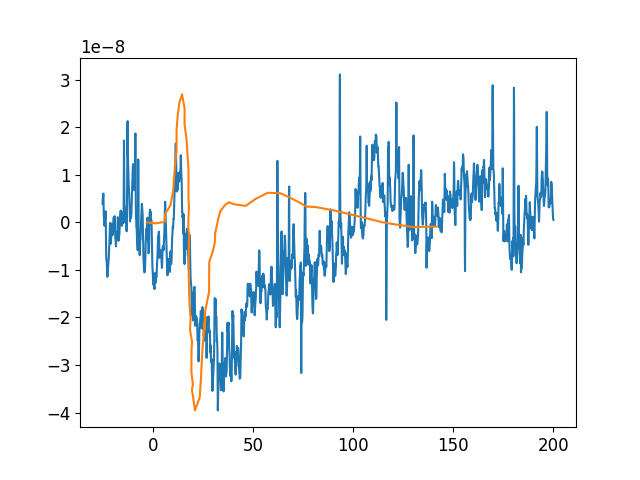

In [55]:
plt.figure()

total = np.sum(np.sum(EEGs[12],axis=0),axis=0)
plt.plot(time,total)
inVivoY = inVivo[:,1]/np.max(np.abs(inVivo[:,1]))*np.max(np.abs(total))
plt.plot(inVivo[:,0]-5,inVivoY)

[ 0 15  6 12  3  9 16  4  1  7 13  8 10  5 17 14  2 11]


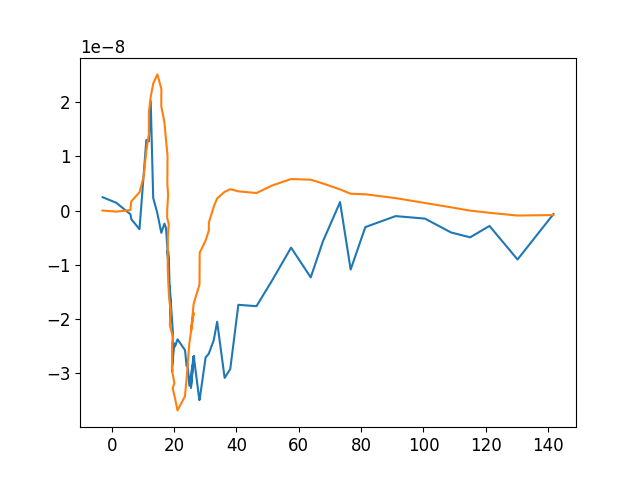

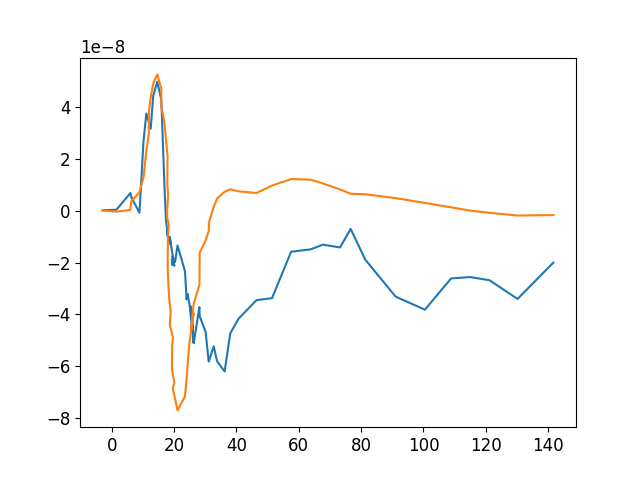

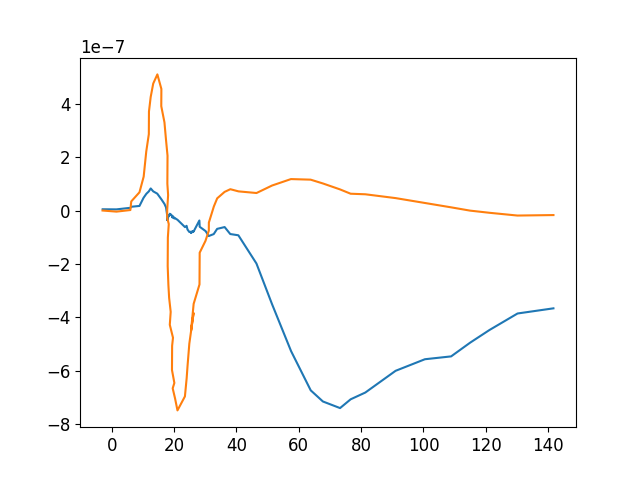

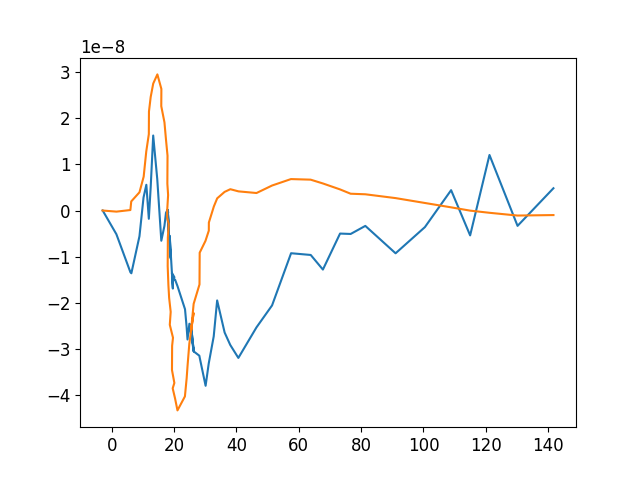

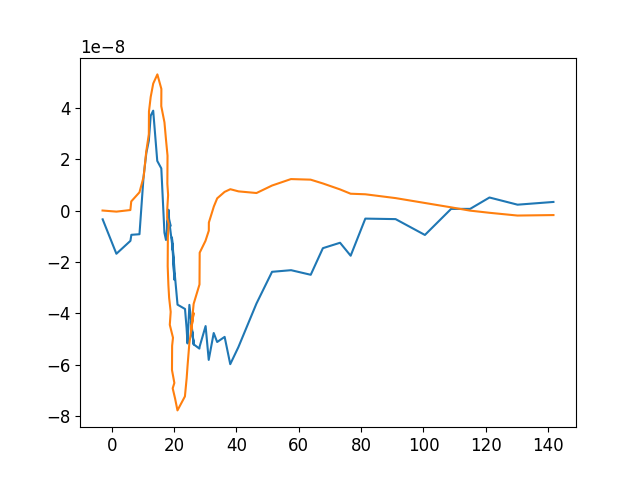

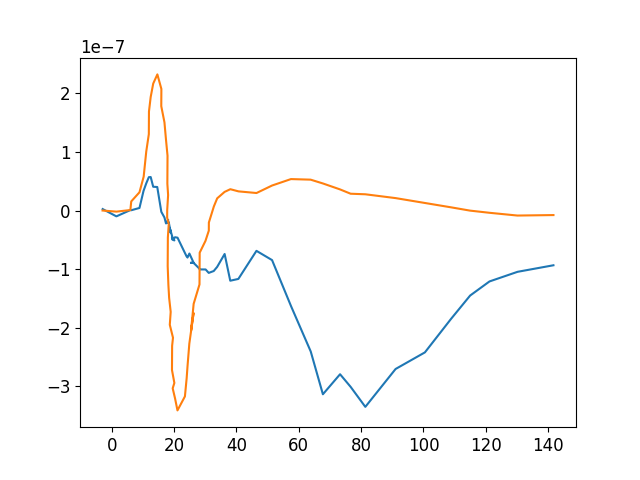

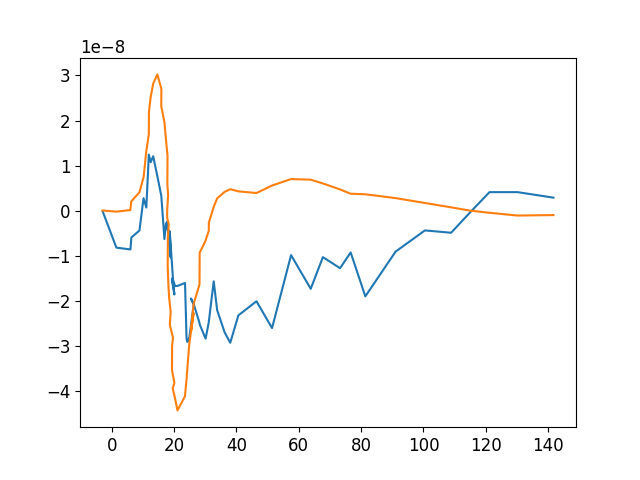

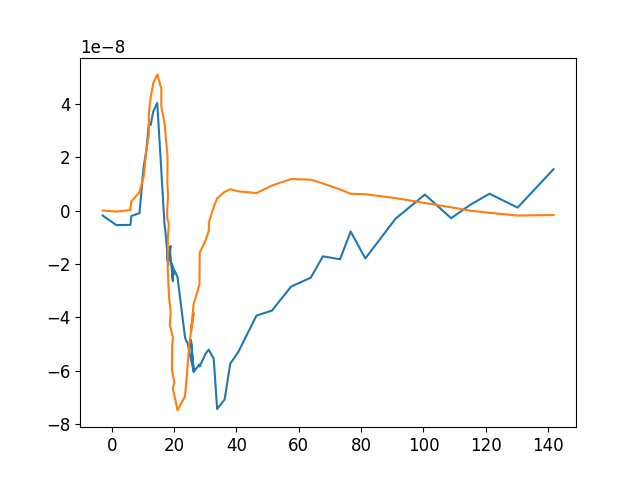

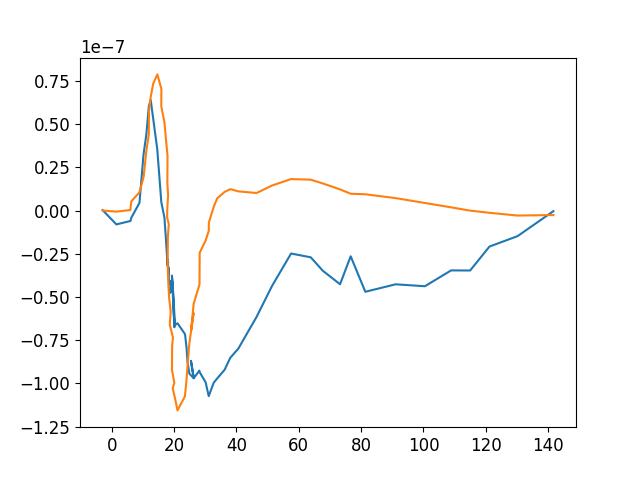

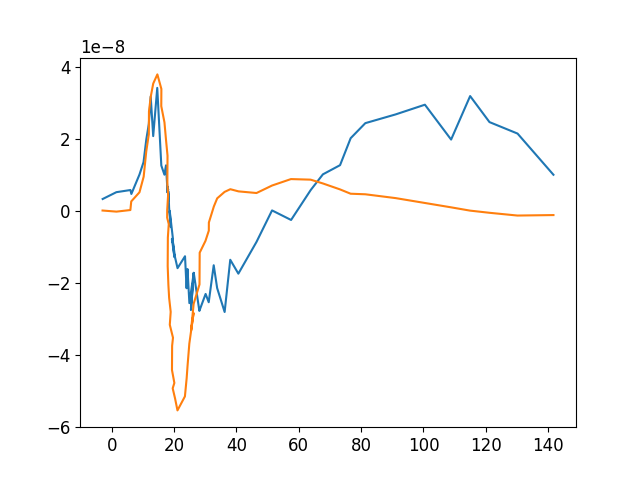

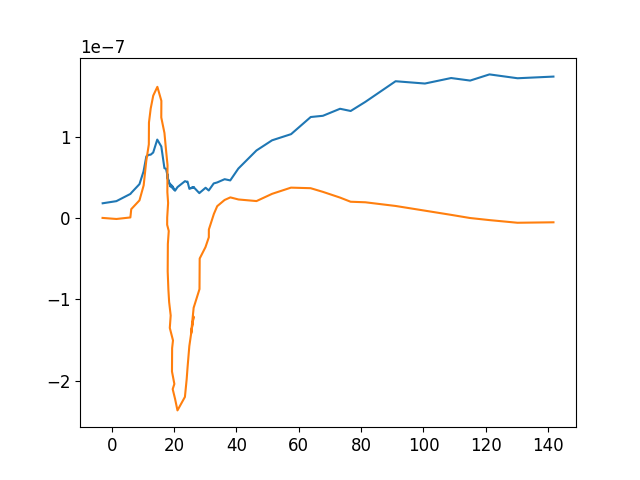

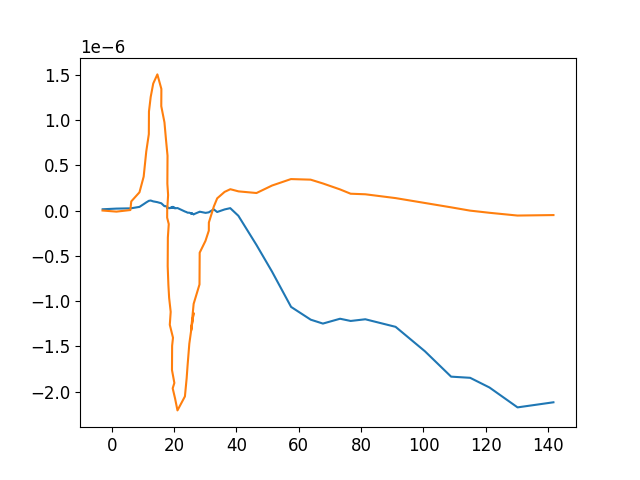

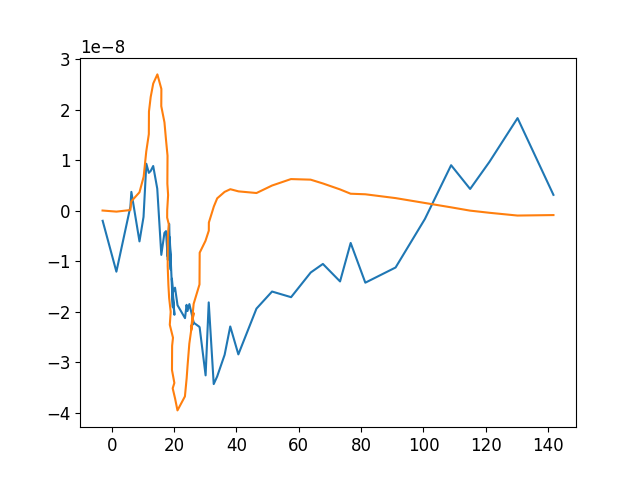

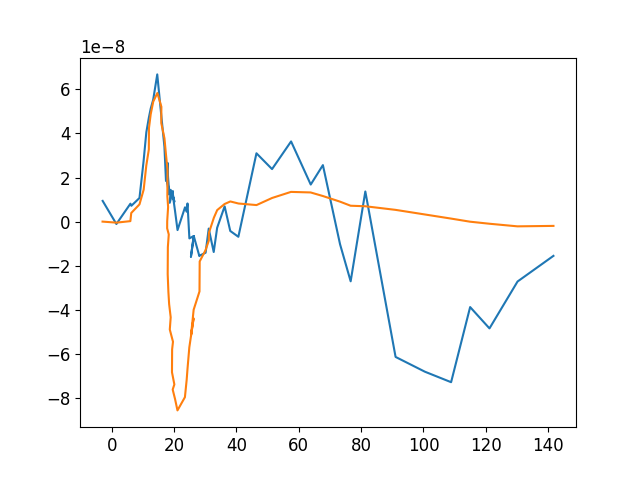

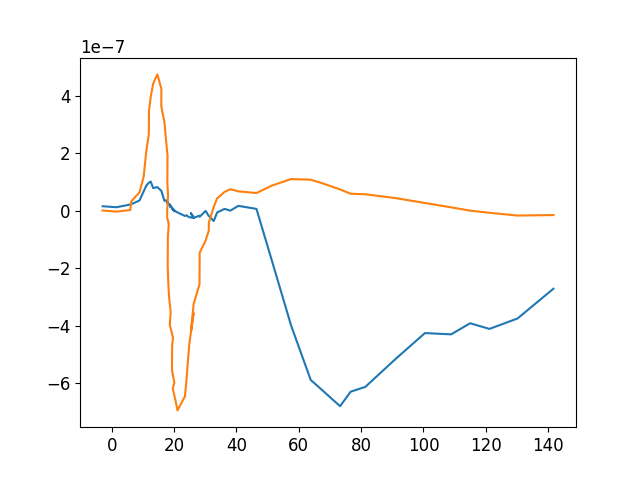

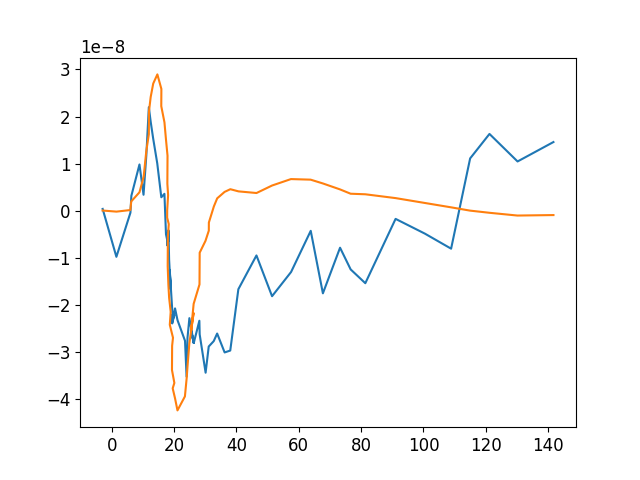

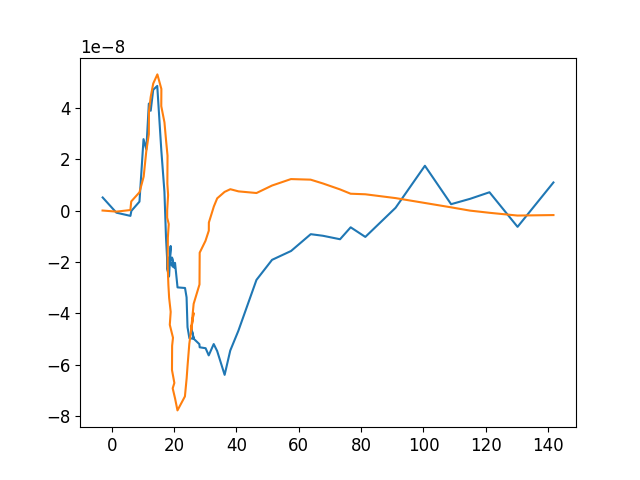

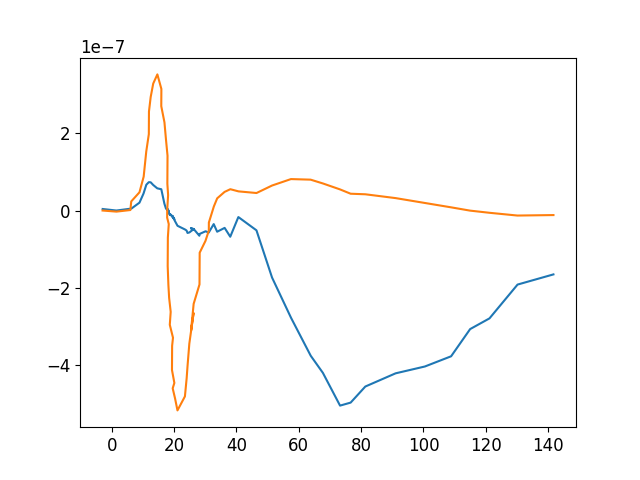

In [56]:
errors = []

for i in range(18):

    plt.figure()

    total = np.sum(np.sum(EEGs[i],axis=0),axis=0)

    inVivoY = inVivo[:,1]/np.max(np.abs(inVivo[:,1]))*np.max(np.abs(total))

    timeIndex = []

    for i in inVivo[:,0]:
        timeIndex.append(np.argmin(np.abs(time+5-i)))

    diff = np.linalg.norm(inVivoY-total[timeIndex])

    errors.append(diff)

    plt.plot(time[timeIndex],total[timeIndex])
    inVivoY = inVivo[:,1]/np.max(np.abs(inVivo[:,1]))*np.max(np.abs(total))
    plt.plot(inVivo[:,0]-5,inVivoY)


    

In [57]:
print(np.argsort(errors))

[ 0 15  6 12  3  9 16  4  1  7 13  8 10  5 17 14  2 11]


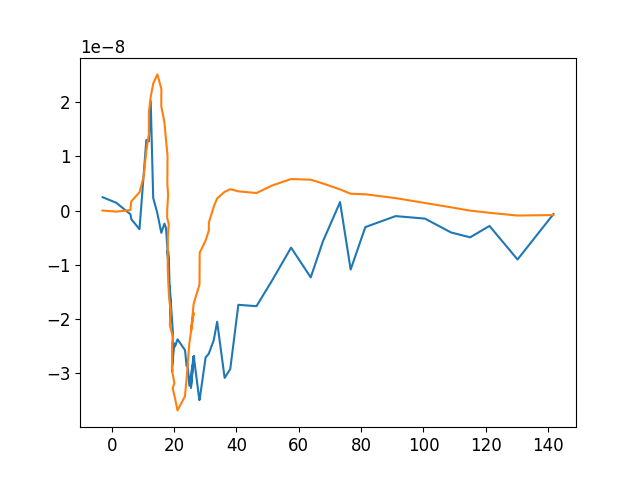

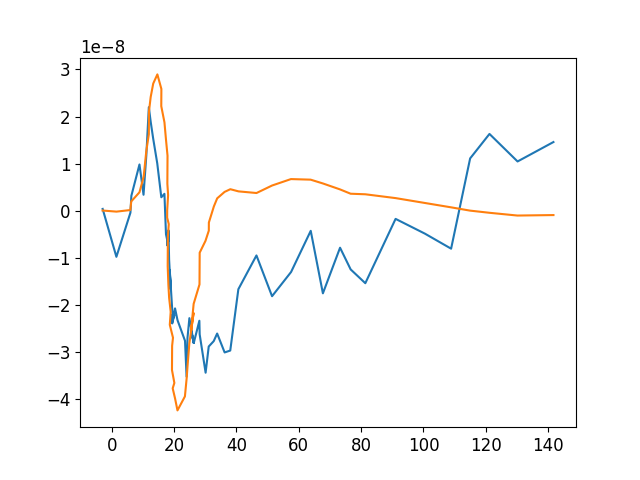

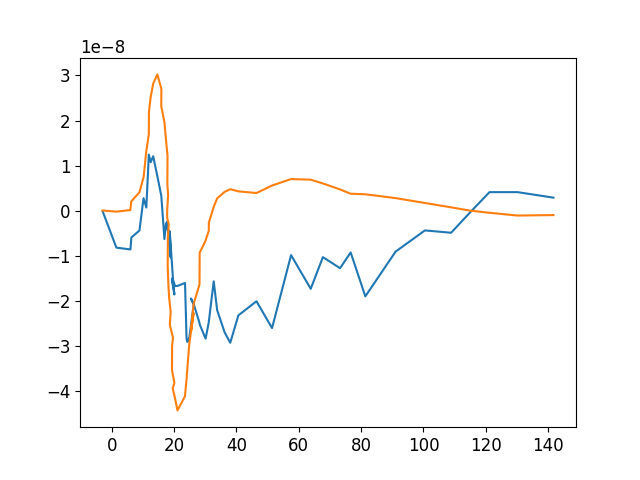

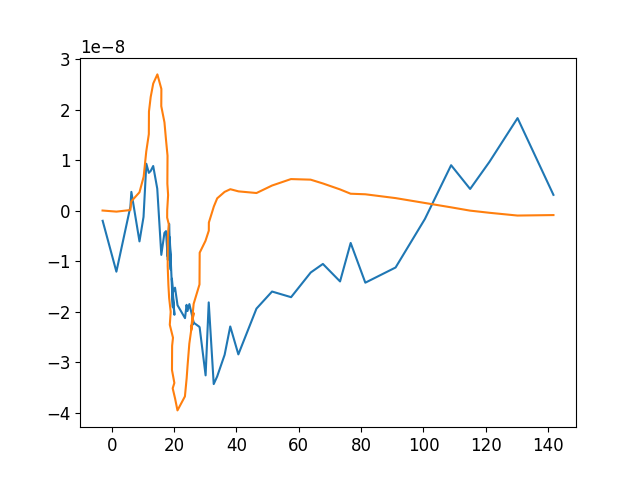

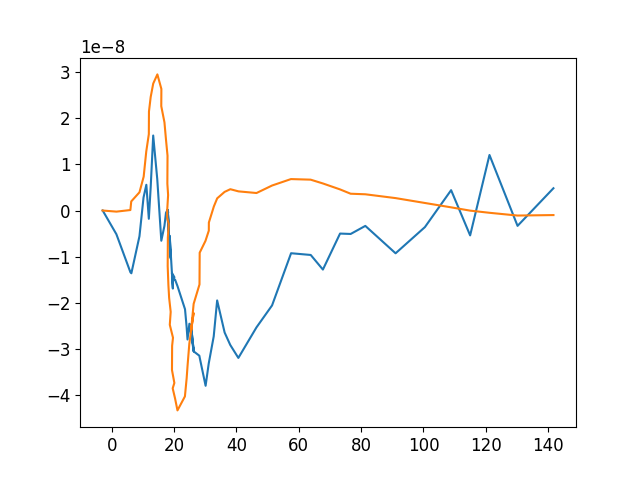

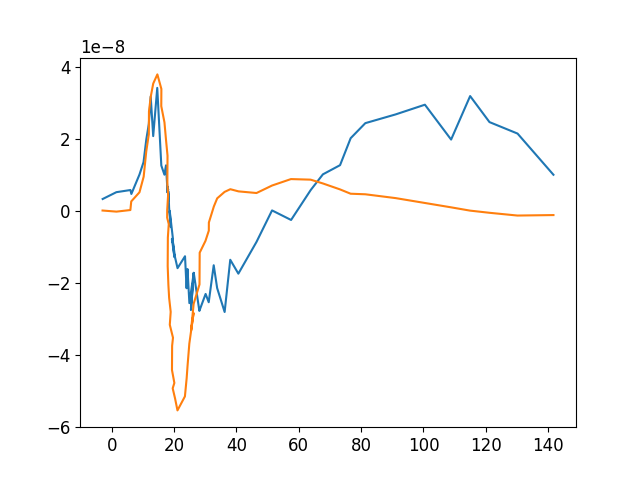

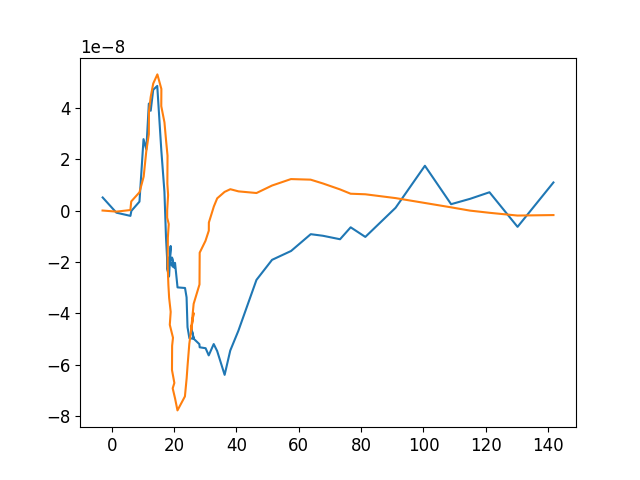

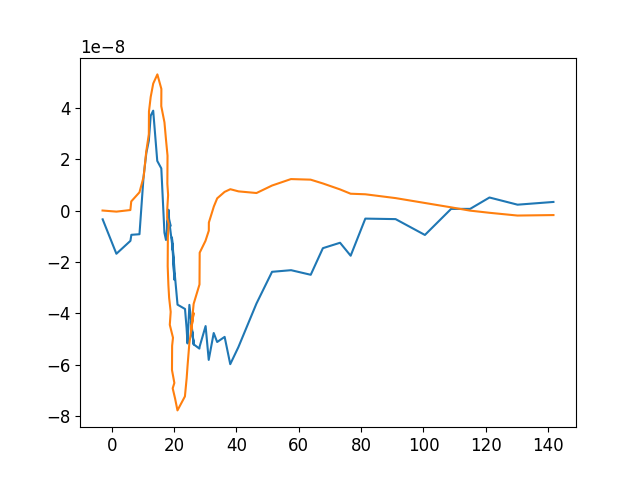

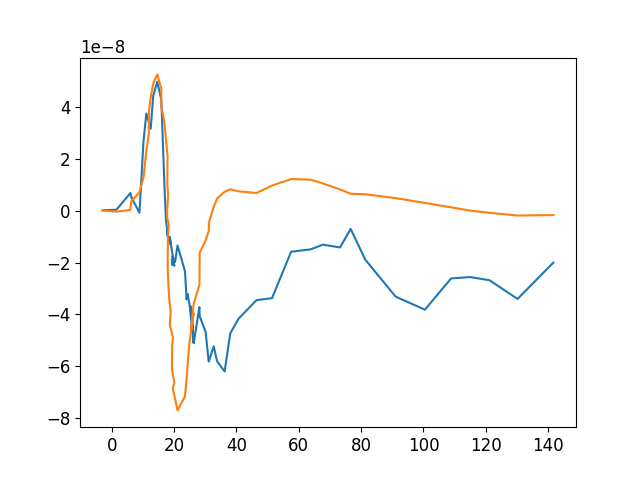

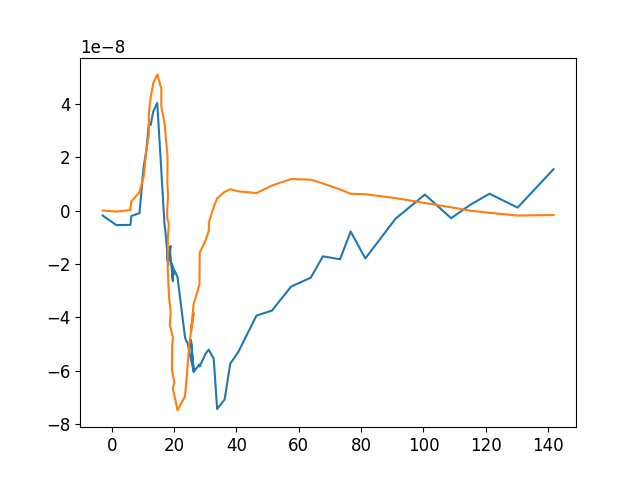

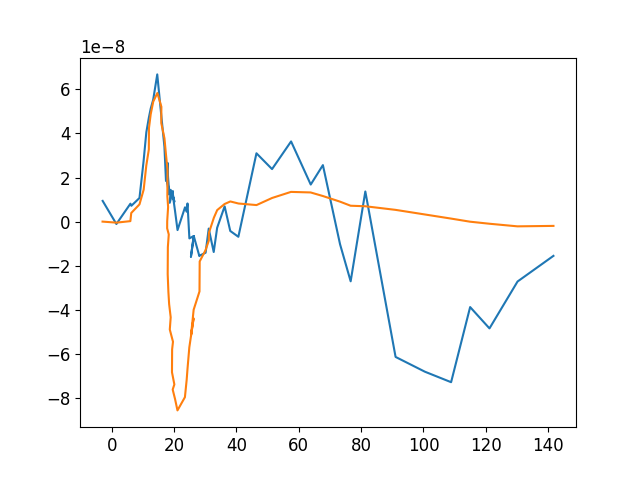

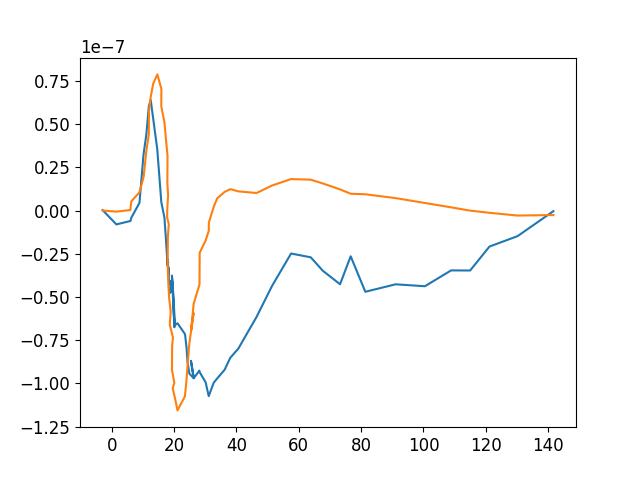

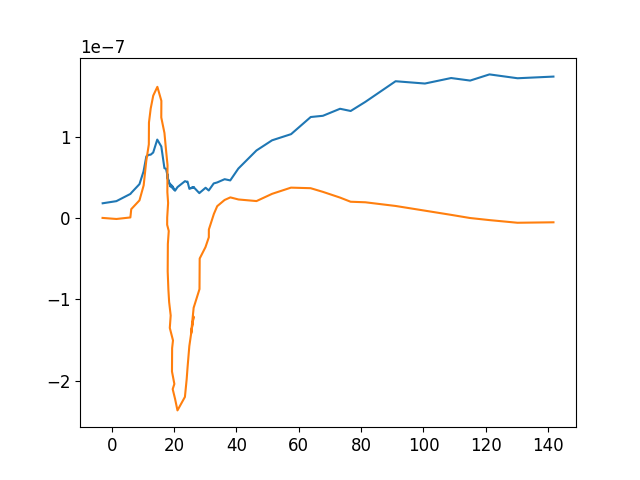

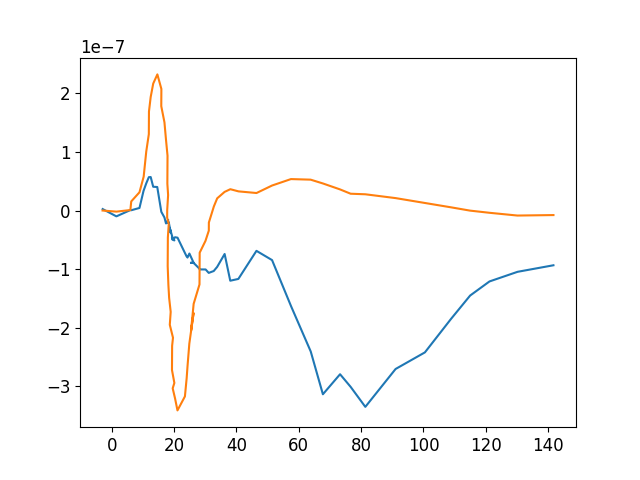

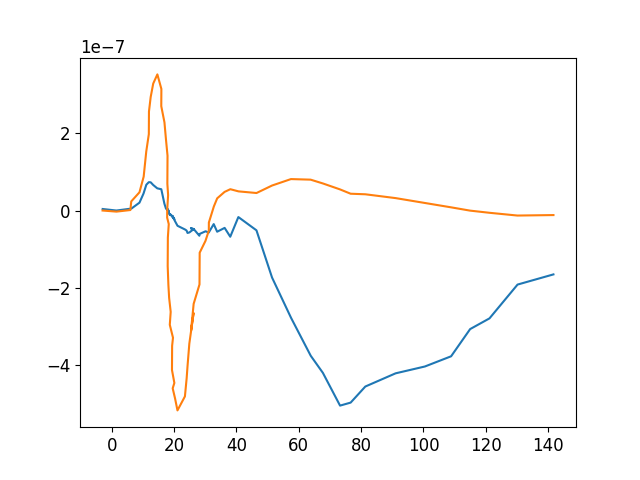

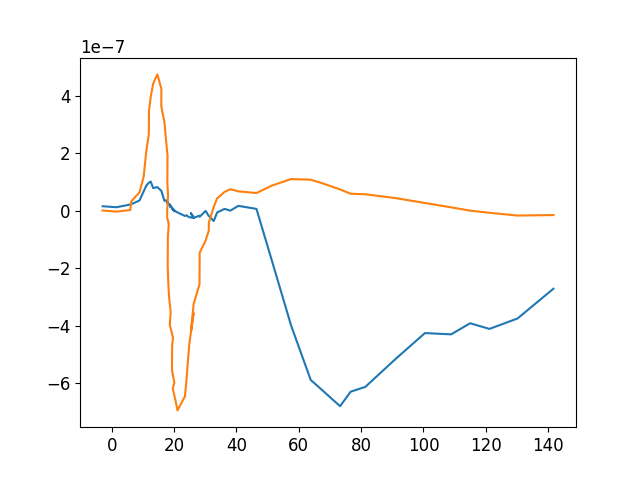

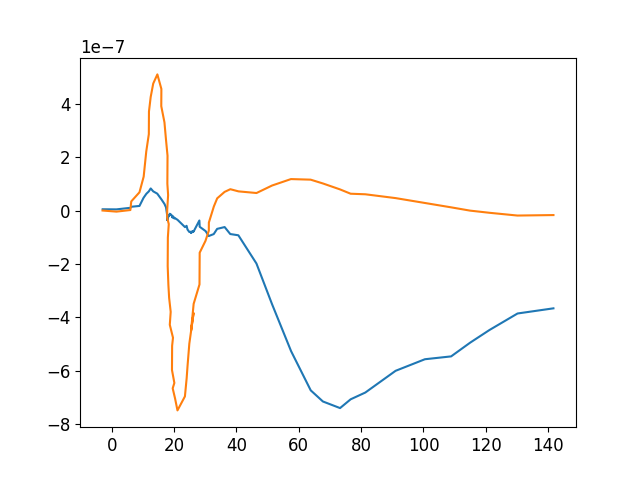

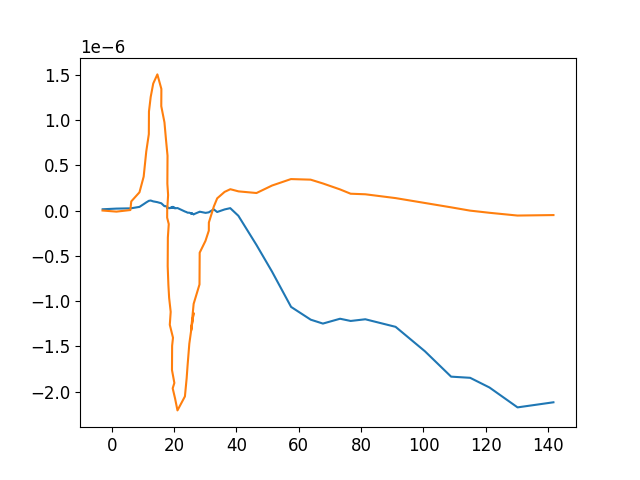

In [60]:
for i in np.argsort(errors):

    plt.figure()

    total = np.sum(np.sum(EEGs[i],axis=0),axis=0)

    inVivoY = inVivo[:,1]/np.max(np.abs(inVivo[:,1]))*np.max(np.abs(total))

    timeIndex = []

    for i in inVivo[:,0]:
        timeIndex.append(np.argmin(np.abs(time+5-i)))

    plt.plot(time[timeIndex],total[timeIndex])
    inVivoY = inVivo[:,1]/np.max(np.abs(inVivo[:,1]))*np.max(np.abs(total))
    plt.plot(inVivo[:,0]-5,inVivoY)